In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
# from IPython.display import Markdown
# from markdown_helper import generate_s3_write_permission_for_sagemaker_role
# import sagemaker
# import boto3
import shutil
import os
import glob
import math
import pandas_profiling
from pandas_profiling import ProfileReport
# from pandas_profiling.utils.cache import cache_file
# pip install --user pandas-profiling==2.8.0 where 2.8.0 is current version on  https://pypi.org/project/pandas-profiling/

#Shapely Library
# conda install -c conda-forge shapely
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

%matplotlib inline

In [3]:
TRAINING_ITERATION = 20

# Helper Functions

In [42]:
def plot_track(df, track_size=(500, 800), x_offset=0, y_offset=0):
    '''
    Each track may have a diff track size, 
    For reinvent track, use track_size=(500, 800)
    Tokyo, track_size=(700, 1000)
    x_offset, y_offset is used to convert to the 0,0 coordinate system
    '''
    track = np.zeros(track_size) # lets magnify the track by *100
    for index, row in df.iterrows():
        # print (row["x"])
        x = int(row["x"] + x_offset)
        y = int(row["y"] + y_offset)
        reward = row["reward"]
        track[y, x] = reward
        
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(111)
    # print_border(ax, center_line, inner_border, outer_border)
    return track

In [17]:
def plot_top_laps(sorted_idx, n_laps=3):
    fig = plt.figure(n_laps, figsize=(12, 30))
    for i in range(n_laps):
        idx = sorted_idx[i]
        
        episode_data = episode_map[idx]
        
        ax = fig.add_subplot(n_laps,1,i+1)
        
        line = LineString(center_line)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border)
        plot_coords(ax, line)
        plot_line(ax, line)


        for idx in range(1, len(episode_data)-1):
            x1,y1,action,reward,angle,speed = episode_data[idx]
            car_x2, car_y2 = x1 - 0.02, y1
            plt.plot([x1, car_x2], [y1, car_y2], 'b.')
        
    return fig

# Load Track

In [4]:
# load track info
def get_track_waypoints(track_name):
    return np.load("%s.npy" % track_name)
    
waypoints = get_track_waypoints("august") ### re:invent track
waypoints.shape

(344, 6)

In [5]:
# visualize track
def plot_points(ax, points):
    ax.scatter(points[:-1,0], points[:-1,1], s=1)
    for i,p in enumerate(points):
        ax.annotate(i, (p[0], p[1]))

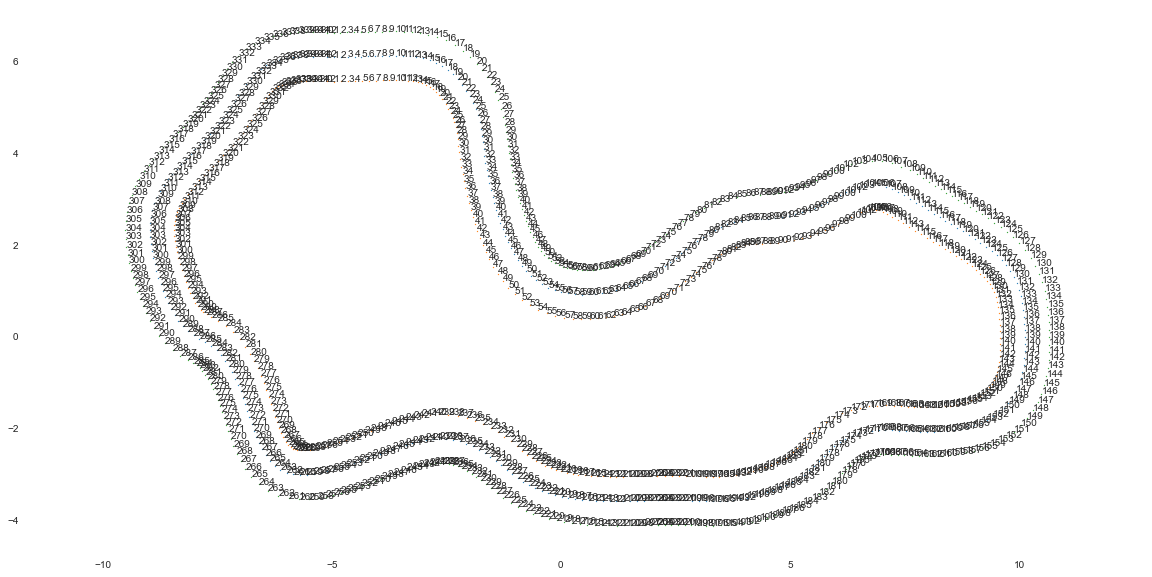

In [6]:
# Plot the results
fig, ax = plt.subplots(figsize=(20,10))
plot_points(ax, waypoints[:-1,0:2])
plot_points(ax, waypoints[:-1,2:4])
plot_points(ax, waypoints[:-1,4:6])
ax.axis('equal')
plt.show()

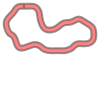

In [7]:
l_center_line = LineString(waypoints[:,0:2])
l_inner_border = LineString(waypoints[:,2:4])
l_outer_border = LineString(waypoints[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))

road_poly

In [8]:
# rescale waypoints to centimeter scale

center_line = waypoints[:,0:2] 
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

# Log File Processing

In [32]:
#load log file
file_path = os.path.join(os.getcwd(), 'DR2L3M7V1202008051.csv')
# now load the data into a pandas dataframe
df = pd.read_csv(file_path)

In [33]:
# handle multiple training episodes concat in one file
iteration_arr = np.arange(math.ceil(df.episode.max()/TRAINING_ITERATION)+1) * TRAINING_ITERATION
df['iteration'] = np.digitize(df.episode, iteration_arr)
df = df.rename(columns={"x-coordinate": "x", "ycoordinate": "y", "time.time()": "timestamp"})
df['x'] = pd.to_numeric(df['x'],errors='coerce')
df['y'] = pd.to_numeric(df['y'],errors='coerce')

In [34]:
df.head()

,episode,step,x,y,heading,steering_angle,speed,action_taken,reward,job_completed,all_wheels_on_track,progress,closest_waypoint_index,track_length,timestamp,Unnamed: 15,iteration
0,0,1,-5.4629,6.0995,-0.4560,-10,1.33,7,1.0,False,True,-0.7004,341,51.39,1596639565,in_progress,1
1,0,2,-5.4606,6.0995,-0.4519,-10,1.33,7,1.0,False,True,-0.6959,341,51.39,1596639565,in_progress,1
2,0,3,-5.4514,6.0991,-0.5783,-10,1.33,7,1.0,False,True,-0.6779,341,51.39,1596639565,in_progress,1
3,0,4,-5.4305,6.0980,-0.8931,-10,1.33,7,1.0,False,True,-0.6372,341,51.39,1596639565,in_progress,1
4,0,5,-5.3833,6.0952,-1.6426,-10,1.33,7,1.0,False,True,-0.5454,341,51.39,1596639565,in_progress,1


In [35]:
df['y'].min(), df['x'].max()

(-3.7493, 9.9163)

In [36]:
# Normalize the rewards to a 0-1 scale

from sklearn.preprocessing import  MinMaxScaler
min_max_scaler = MinMaxScaler()
scaled_vals = min_max_scaler.fit_transform(df['reward'].values.reshape(df['reward'].values.shape[0], 1))
df['reward'] = pd.DataFrame(scaled_vals.squeeze())

In [37]:
df['reward'].min(), df['reward'].max()

(0.0, 1.0)

<AxesSubplot:xlabel='x'>

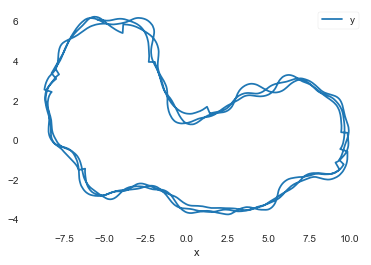

In [38]:
df.plot(x='x', y='y')
# df.plot(x='timestamp', y='reward')
# df.plot(x='timestamp', y='speed')

In [20]:
# profile = ProfileReport(df)
# profile = ProfileReport(df, title='AWS Deep Racer', html={'style':{'full_width':True}}, sort='None')
# profile.to_notebook_iframe()
# profile.to_file(output_file='AWSDeepRacerLogProfile')

In [39]:
print("Min x-axis {}; Max x-axis {}".format(np.min(df['x']), np.max(df['x'])))
print("Min y-axis {}; Max y-axis {}".format(np.min(df['y']), np.max(df['y'])))

Min x-axis -8.6948; Max x-axis 9.9163
Min y-axis -3.7493; Max y-axis 6.2441


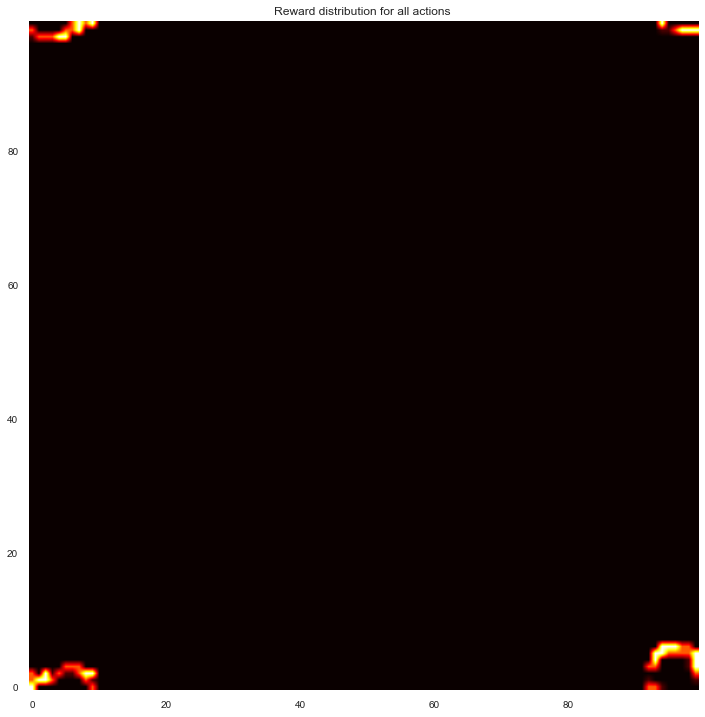

In [45]:
track = plot_track(df, track_size=(100, 100), x_offset=0, y_offset=0)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower")